# Step 0: Introduction
This is my version of the Google Data Analytics Certification's capstone project 2. In this study, I will be analyzing Fitbit data to gain insights for the developing marketing strategy for Bellabeat. 

# Step 1: Ask
#### Guiding Questions
1. What are some trends in smart device usage?
2. How could these trends apply to Bellabeat customers?
3. How could these trends help influence Bellabeat marketing strategy?

# Step 2: Prepare
* The data is provided on [kaggle](https://www.kaggle.com/datasets/arashnic/fitbit).
* The data was collected between April 2016 and May 2016.

# Step 3: Process
Created a separate folder and moved the downloaded files to the folder.

## 3.1 Code

In [1]:
# import required packages
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

### 3.1.1 Collect Data

In [2]:
# set directory
os.chdir('C:\\Users\\peter\\OneDrive\\Desktop\\Spring 2021\\Google Data Analytics\\Wellness\\Fitbit')

In [3]:
# upload the data
daily_activity = pd.read_csv('dailyActivity_merged.csv')
daily_calories = pd.read_csv('dailyCalories_merged.csv')
daily_intensities = pd.read_csv('dailyIntensities_merged.csv')
daily_steps = pd.read_csv('dailySteps_merged.csv')
sleep_day = pd.read_csv('sleepDay_merged.csv')
weight_info = pd.read_csv('weightLogInfo_merged.csv')

### 3.1.2 Clean the Data

In [4]:
# change data type of the date columns
daily_activity['ActivityDate'] = pd.to_datetime(daily_activity['ActivityDate'], format='%m/%d/%Y')
daily_calories['ActivityDay'] = pd.to_datetime(daily_calories['ActivityDay'], format='%m/%d/%Y')
daily_intensities['ActivityDay'] = pd.to_datetime(daily_intensities['ActivityDay'], format='%m/%d/%Y')
daily_steps['ActivityDay'] = pd.to_datetime(daily_steps['ActivityDay'], format='%m/%d/%Y')
sleep_day['SleepDay'] = pd.to_datetime(sleep_day['SleepDay'], format='%m/%d/%Y %I:%M:%S %p')
weight_info['Date'] = pd.to_datetime(weight_info['Date'], format='%m/%d/%Y %I:%M:%S %p')
weight_info['ActivityDay'] = pd.to_datetime(weight_info['Date']).dt.date
weight_info['ActivityDay'] = pd.to_datetime(weight_info['ActivityDay']).dt.normalize()

In [5]:
# rename columns for consistency
daily_activity.rename(columns={'ActivityDate': 'ActivityDay'}, inplace=True)
daily_steps.rename(columns={'StepTotal': 'TotalSteps'}, inplace=True)
sleep_day.rename(columns={'SleepDay': 'ActivityDay'}, inplace=True)

### 3.1.3 Add the Data

In [6]:
# check null values
tables = [daily_activity, daily_calories, daily_intensities, daily_steps, sleep_day, weight_info]
for table in tables:
    print(table.isnull().sum())

Id                          0
ActivityDay                 0
TotalSteps                  0
TotalDistance               0
TrackerDistance             0
LoggedActivitiesDistance    0
VeryActiveDistance          0
ModeratelyActiveDistance    0
LightActiveDistance         0
SedentaryActiveDistance     0
VeryActiveMinutes           0
FairlyActiveMinutes         0
LightlyActiveMinutes        0
SedentaryMinutes            0
Calories                    0
dtype: int64
Id             0
ActivityDay    0
Calories       0
dtype: int64
Id                          0
ActivityDay                 0
SedentaryMinutes            0
LightlyActiveMinutes        0
FairlyActiveMinutes         0
VeryActiveMinutes           0
SedentaryActiveDistance     0
LightActiveDistance         0
ModeratelyActiveDistance    0
VeryActiveDistance          0
dtype: int64
Id             0
ActivityDay    0
TotalSteps     0
dtype: int64
Id                    0
ActivityDay           0
TotalSleepRecords     0
TotalMinutesAsleep    0


In [7]:
# assign mean value to null values
weight_info['Fat'].fillna(int(weight_info['Fat'].mean()), inplace=True)
weight_info['Fat'].value_counts()

23.0    65
22.0     1
25.0     1
Name: Fat, dtype: int64

In [8]:
# check duplicates
for table in tables:
    print(table.duplicated().sum())

0
0
0
0
3
0


In [9]:
# drop duplicates
sleep_day.drop_duplicates(inplace=True)
sleep_day.duplicated().sum()

0

#### 3.1.3.1 First four tables have same row number or same number of unique id.

In [10]:
# look at numbers of rows and columns
for table in tables:
    print(table.shape)

(940, 15)
(940, 3)
(940, 10)
(940, 3)
(410, 5)
(67, 9)


In [11]:
# look at uniques of 'Id' columns
for table in tables:
    print(len(table['Id'].unique()))  

33
33
33
33
24
8


In [12]:
# check shared columns name
for table in tables[:4]:
    print(table.columns)

Index(['Id', 'ActivityDay', 'TotalSteps', 'TotalDistance', 'TrackerDistance',
       'LoggedActivitiesDistance', 'VeryActiveDistance',
       'ModeratelyActiveDistance', 'LightActiveDistance',
       'SedentaryActiveDistance', 'VeryActiveMinutes', 'FairlyActiveMinutes',
       'LightlyActiveMinutes', 'SedentaryMinutes', 'Calories'],
      dtype='object')
Index(['Id', 'ActivityDay', 'Calories'], dtype='object')
Index(['Id', 'ActivityDay', 'SedentaryMinutes', 'LightlyActiveMinutes',
       'FairlyActiveMinutes', 'VeryActiveMinutes', 'SedentaryActiveDistance',
       'LightActiveDistance', 'ModeratelyActiveDistance',
       'VeryActiveDistance'],
      dtype='object')
Index(['Id', 'ActivityDay', 'TotalSteps'], dtype='object')


In [13]:
# merge daily_activity and daily_intensities first
activity_intensities = daily_activity.merge(daily_intensities, how='left',
                                           on=['Id', 'ActivityDay', 'SedentaryMinutes', 'LightlyActiveMinutes', 
                                               'FairlyActiveMinutes', 'VeryActiveMinutes', 'SedentaryActiveDistance',
                                               'LightActiveDistance', 'ModeratelyActiveDistance', 'VeryActiveDistance'])

In [14]:
# merged daily_calories and daily_steps
calories_steps = daily_calories.merge(daily_steps, how='left', on=['Id', 'ActivityDay'])

In [15]:
# finally merge two recently merged datasets
data_merged = activity_intensities.merge(calories_steps, how='left', on=['Id', 'ActivityDay', 'Calories', 'TotalSteps'])

In [16]:
# check whether number of columns is the same
data_merged.shape

(940, 15)

In [17]:
# add day of week column
from pandas.api.types import CategoricalDtype
data_merged['DayofWeek'] = data_merged['ActivityDay'].dt.day_name()
sorter = ['Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday']
category_day = CategoricalDtype(categories=sorter, ordered=True)
data_merged['DayofWeek'] = data_merged['DayofWeek'].astype(category_day)

# Step 4: Analyze

## 4.1 Code

### 4.1.1 Conduct Descrptive Analysis

In [18]:
# summary of the merged dataset
data_merged.describe()

,Id,TotalSteps,TotalDistance,TrackerDistance,LoggedActivitiesDistance,VeryActiveDistance,ModeratelyActiveDistance,LightActiveDistance,SedentaryActiveDistance,VeryActiveMinutes,FairlyActiveMinutes,LightlyActiveMinutes,SedentaryMinutes,Calories
count,9.400000e+02,940.000000,940.000000,940.000000,940.000000,940.000000,940.000000,940.000000,940.000000,940.000000,940.000000,940.000000,940.000000,940.000000
mean,4.855407e+09,7637.910638,5.489702,5.475351,0.108171,1.502681,0.567543,3.340819,0.001606,21.164894,13.564894,192.812766,991.210638,2303.609574
std,2.424805e+09,5087.150742,3.924606,3.907276,0.619897,2.658941,0.883580,2.040655,0.007346,32.844803,19.987404,109.174700,301.267437,718.166862
min,1.503960e+09,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.320127e+09,3789.750000,2.620000,2.620000,0.000000,0.000000,0.000000,1.945000,0.000000,0.000000,0.000000,127.000000,729.750000,1828.500000
50%,4.445115e+09,7405.500000,5.245000,5.245000,0.000000,0.210000,0.240000,3.365000,0.000000,4.000000,6.000000,199.000000,1057.500000,2134.000000
75%,6.962181e+09,10727.000000,7.712500,7.710000,0.000000,2.052500,0.800000,4.782500,0.000000,32.000000,19.000000,264.000000,1229.500000,2793.250000
max,8.877689e+09,36019.000000,28.030001,28.030001,4.942142,21.920000,6.480000,10.710000,0.110000,210.000000,143.000000,518.000000,1440.000000,4900.000000


In [19]:
# summary of sleep_day
sleep_day.describe()

,Id,TotalSleepRecords,TotalMinutesAsleep,TotalTimeInBed
count,4.100000e+02,410.000000,410.000000,410.000000
mean,4.994963e+09,1.119512,419.173171,458.482927
std,2.060863e+09,0.346636,118.635918,127.455140
min,1.503960e+09,1.000000,58.000000,61.000000
25%,3.977334e+09,1.000000,361.000000,403.750000
50%,4.702922e+09,1.000000,432.500000,463.000000
75%,6.962181e+09,1.000000,490.000000,526.000000
max,8.792010e+09,3.000000,796.000000,961.000000


In [20]:
# summary of weight_info
weight_info.describe()

,Id,WeightKg,WeightPounds,Fat,BMI,LogId
count,6.700000e+01,67.000000,67.000000,67.000000,67.000000,6.700000e+01
mean,7.009282e+09,72.035821,158.811801,23.014925,25.185224,1.461772e+12
std,1.950322e+09,13.923206,30.695415,0.274830,3.066963,7.829948e+08
min,1.503960e+09,52.599998,115.963147,22.000000,21.450001,1.460444e+12
25%,6.962181e+09,61.400002,135.363832,23.000000,23.959999,1.461079e+12
50%,6.962181e+09,62.500000,137.788914,23.000000,24.389999,1.461802e+12
75%,8.877689e+09,85.049999,187.503152,23.000000,25.559999,1.462375e+12
max,8.877689e+09,133.500000,294.317120,25.000000,47.540001,1.463098e+12


#### 4.1.1.0 There is no relation between types of activity and their distance

In [21]:
# types of activity percentage
very = (data_merged['VeryActiveMinutes'].sum()/data_merged.iloc[:,9:14].sum().sum()) * 100
fairly = (data_merged['FairlyActiveMinutes'].sum()/data_merged.iloc[:,9:14].sum().sum()) * 100
lightly = (data_merged['LightlyActiveMinutes'].sum()/data_merged.iloc[:,9:14].sum().sum()) * 100
sedentary = (data_merged['SedentaryMinutes'].sum()/data_merged.iloc[:,9:14].sum().sum()) * 100

print(f"The very active minutes is: {very:.2f}%")
print(f"The fairly active minutes is: {fairly:.2f}%")
print(f"The lightly active minutes is: {lightly:.2f}%")
print(f"The sedendary minutes is: {sedentary:.2f}%")

very_distance = (data_merged['VeryActiveDistance'].sum()/data_merged.iloc[:,6:10].sum().sum()) * 100
moderate_distance = (data_merged['ModeratelyActiveDistance'].sum()/data_merged.iloc[:,6:10].sum().sum()) * 100
light_distance = (data_merged['LightActiveDistance'].sum()/data_merged.iloc[:,6:10].sum().sum()) * 100
sedentary_distance = (data_merged['SedentaryActiveDistance'].sum()/data_merged.iloc[:,6:10].sum().sum()) * 100

print("")
print(f"The very active distance is: {very_distance:.2f}%")
print(f"The fairly active distance is: {moderate_distance:.2f}%")
print(f"The lightly active distance is: {light_distance:.2f}%")
print(f"The sedendary distance is: {sedentary_distance:.2f}%")

The very active minutes is: 1.74%
The fairly active minutes is: 1.11%
The lightly active minutes is: 15.82%
The sedendary minutes is: 81.33%

The very active distance is: 27.76%
The fairly active distance is: 10.49%
The lightly active distance is: 61.72%
The sedendary distance is: 0.03%


In [22]:
# averge minutes by type of activity
data_merged.groupby('DayofWeek')['VeryActiveMinutes', 'FairlyActiveMinutes',
       'LightlyActiveMinutes', 'SedentaryMinutes'].mean()

,VeryActiveMinutes,FairlyActiveMinutes,LightlyActiveMinutes,SedentaryMinutes
DayofWeek,,,,
Sunday,19.983471,14.528926,173.975207,990.256198
Monday,23.108333,14.000000,192.058333,1027.941667
Tuesday,22.953947,14.335526,197.342105,1007.361842
Wednesday,20.780000,13.100000,189.853333,989.480000
Thursday,19.408163,11.959184,185.421769,961.993197
Friday,20.055556,12.111111,204.198413,1000.309524
Saturday,21.919355,15.201613,207.145161,964.282258


In [23]:
data_merged.groupby('DayofWeek')['VeryActiveDistance', 'ModeratelyActiveDistance',
       'LightActiveDistance', 'SedentaryActiveDistance'].sum()

,VeryActiveDistance,ModeratelyActiveDistance,LightActiveDistance,SedentaryActiveDistance
DayofWeek,,,,
Sunday,180.160000,74.779999,349.970002,0.08
Monday,184.480001,70.300000,403.570000,0.31
Tuesday,245.220001,90.140000,527.599999,0.22
Wednesday,245.020000,79.060000,488.450001,0.20
Thursday,204.400001,74.260000,482.620000,0.34
Friday,165.429999,60.960000,439.629998,0.23
Saturday,187.809998,83.989999,448.530000,0.13


#### 4.1.1.1 There are relations between types of activity and amount of calories burnt

In [24]:
# coefficients of determinations explain how calories are burnt depending on activity types
calories_very_active = np.corrcoef(data_merged['VeryActiveMinutes'], data_merged['Calories'])
calories_fairly_active = np.corrcoef(data_merged['FairlyActiveMinutes'], data_merged['Calories'])
calories_lightly_active = np.corrcoef(data_merged['LightlyActiveMinutes'], data_merged['Calories'])
calories_sedentary = np.corrcoef(data_merged['SedentaryMinutes'], data_merged['Calories'])
                                      
print(f"Coefficient of Determination: {round(calories_very_active[0][1], 2)}")
print(f"Coefficient of Determination: {round(calories_fairly_active[0][1], 2)}")
print(f"Coefficient of Determination: {round(calories_lightly_active[0][1], 2)}")
print(f"Coefficient of Determination: {round(calories_sedentary[0][1], 2)}")

Coefficient of Determination: 0.62
Coefficient of Determination: 0.3
Coefficient of Determination: 0.29
Coefficient of Determination: -0.11


#### 4.1.1.2 There are strong relations between total steps and amount of calories burnt

In [25]:
# coefficient of determination explain how calories are burnt as steps are taken
steps_calories = np.corrcoef(data_merged['TotalSteps'], data_merged['Calories'])

print(f"Coefficient of Determination: {round(steps_calories[0][1], 2)}")

Coefficient of Determination: 0.59


In [26]:
# coefficients of determinations explain how steps are efficiently taken depending on activity types
steps_very_active = np.corrcoef(data_merged['VeryActiveMinutes'], data_merged['TotalSteps'])
steps_fairly_active = np.corrcoef(data_merged['FairlyActiveMinutes'], data_merged['TotalSteps'])
steps_lightly_active = np.corrcoef(data_merged['LightlyActiveMinutes'], data_merged['TotalSteps'])
steps_sedentary = np.corrcoef(data_merged['SedentaryMinutes'], data_merged['TotalSteps'])

print(f"Coefficient of Determination: {round(steps_very_active[0][1], 2)}")
print(f"Coefficient of Determination: {round(steps_fairly_active[0][1], 2)}")
print(f"Coefficient of Determination: {round(steps_lightly_active[0][1], 2)}")
print(f"Coefficient of Determination: {round(steps_sedentary[0][1], 2)}")

Coefficient of Determination: 0.67
Coefficient of Determination: 0.5
Coefficient of Determination: 0.57
Coefficient of Determination: -0.33


#### 4.1.1.3 There are the relations between total sleep time and active minutes or total time in bed

In [27]:
# assign new manipulated columns (very and fairly as active, & lightly and sedentary as non-active)
data_temp = data_merged.assign(active_distance = data_merged.iloc[:, 6:8].sum(axis=1),
                               non_active_distance = data_merged.iloc[:,8:10].sum(axis=1),
                               active_minutes = data_merged.iloc[:,-6:-4].sum(axis=1), 
                               non_active_minutes = data_merged.iloc[:,-4:-2].sum(axis=1))

In [28]:
# merge with sleep_day dataset
sleep_merged = sleep_day.merge(data_temp, how='inner', on=['Id', 'ActivityDay'])

In [29]:
# coefficients of determinations explain how non-active or active minutes affect minutes asleep
non_active_sleep = np.corrcoef(sleep_merged['non_active_minutes'], sleep_merged['TotalMinutesAsleep'])
active_sleep = np.corrcoef(sleep_merged['active_minutes'], sleep_merged['TotalMinutesAsleep'])
bedtime_sleep = np.corrcoef(sleep_merged['TotalTimeInBed'], sleep_merged['TotalMinutesAsleep'])
# active_sleep = np.corrcoef(sleep_merged['Sedentary'], sleep_merged['TotalTimeInBed'])

print(f"Coefficient of Determination: {round(non_active_sleep[0][1], 2)}")
print(f"Coefficient of Determination: {round(active_sleep[0][1], 2)}")
print(f"Coefficient of Determination: {round(bedtime_sleep[0][1], 2)}")

Coefficient of Determination: -0.59
Coefficient of Determination: -0.18
Coefficient of Determination: 0.93


#### 4.1.1.4 There are little or small relations between body mass and non-active or active minutes

In [30]:
# merge with weight_info dataset
weight_merged = weight_info.merge(data_temp, how='inner', on=['Id', 'ActivityDay'])

In [31]:
# coefficients of determinations explain how body fat could be gained or lost depending on how long is duration of being active
non_active_bmi = np.corrcoef(weight_merged['non_active_minutes'], weight_merged['BMI'])
active_bmi = np.corrcoef(weight_merged['active_minutes'], weight_merged['BMI'])

print(f"Coefficient of Determination: {round(non_active_bmi[0][1], 2)}")
print(f"Coefficient of Determination: {round(active_bmi[0][1], 2)}")

Coefficient of Determination: 0.17
Coefficient of Determination: -0.03


#### 4.1.1.5 Users take about 30 to 50 minutes in bed before they fall asleep, especially in Sunday and Saturday nights

In [32]:
print(f"Average Time Asleep in Hours:\n {round(sleep_merged.groupby('DayofWeek')['TotalMinutesAsleep'].mean()/60, 2)}\n")

print(f"Minutes in Bed Before Asleep:\
    \n{round(sleep_merged.groupby('DayofWeek')['TotalTimeInBed'].mean() - sleep_merged.groupby('DayofWeek')['TotalMinutesAsleep'].mean(), 2)}")

Average Time Asleep in Hours:
 DayofWeek
Sunday       7.55
Monday       6.99
Tuesday      6.74
Wednesday    7.24
Thursday     6.69
Friday       6.76
Saturday     6.98
Name: TotalMinutesAsleep, dtype: float64

Minutes in Bed Before Asleep:    
DayofWeek
Sunday       50.76
Monday       37.85
Tuesday      38.75
Wednesday    35.35
Thursday     33.58
Friday       39.63
Saturday     40.77
dtype: float64


# Step 5: Share

## 5.1 Code

### 5.1.1 Visualize the Analysis

#### 5.1.1.0 Visualization shows the relations between types of activity and their distances

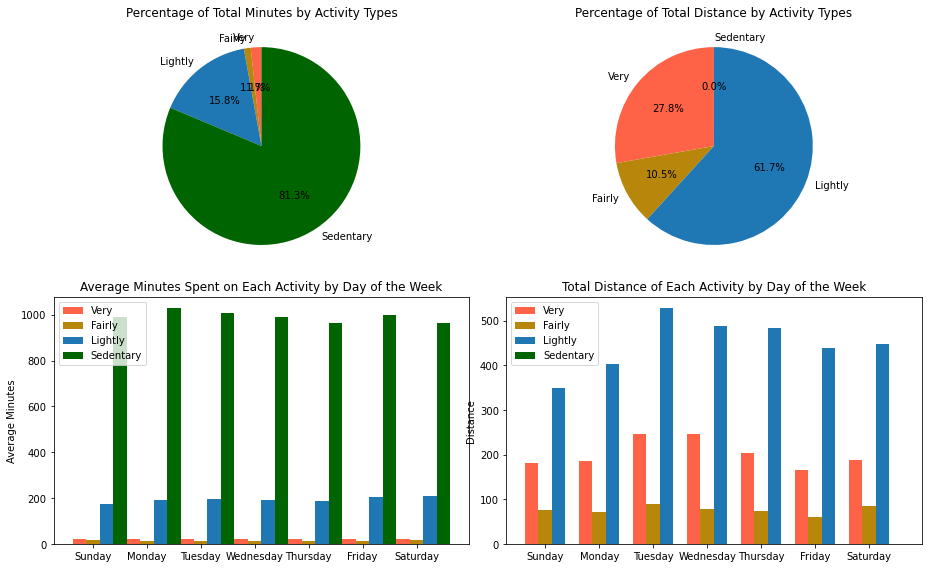

In [33]:
plt.figure(figsize=(13,8))

plt.subplot(2,2,1)
plt.pie([data_merged['VeryActiveMinutes'].sum(), data_merged['FairlyActiveMinutes'].sum(), 
         data_merged['LightlyActiveMinutes'].sum(), data_merged['SedentaryMinutes'].sum()],
        labels=['Very', 'Fairly', 'Lightly', 'Sedentary'], colors=['tomato', 'darkgoldenrod', '#1f77b4', 'darkgreen'],
        startangle=90,
        autopct='%1.1f%%')
plt.title('Percentage of Total Minutes by Activity Types')
plt.tight_layout()

plt.subplot(2,2,2)
plt.pie([data_merged['VeryActiveDistance'].sum(), data_merged['ModeratelyActiveDistance'].sum(), 
         data_merged['LightActiveDistance'].sum(), data_merged['SedentaryActiveDistance'].sum()],
        labels=['Very', 'Fairly', 'Lightly', 'Sedentary'], colors=['tomato', 'darkgoldenrod', '#1f77b4', 'darkgreen'],
        startangle=90,
        autopct='%1.1f%%')
plt.title('Percentage of Total Distance by Activity Types')
plt.tight_layout()

plt.subplot(2,2,3)
x = np.arange(7)
x_labels = ['Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday']
width = 0.25
plt.bar(x - width, data_merged.groupby('DayofWeek')['VeryActiveMinutes'].mean(),
        width=width, color='tomato', label='Very')
plt.bar(x, data_merged.groupby('DayofWeek')['FairlyActiveMinutes'].mean(), 
        width=width, color='darkgoldenrod', label='Fairly')
plt.bar(x + width, data_merged.groupby('DayofWeek')['LightlyActiveMinutes'].mean(), 
        width=width, color='#1f77b4', label='Lightly')
plt.bar(x + width*2, data_merged.groupby('DayofWeek')['SedentaryMinutes'].mean(), 
        width=width, color='darkgreen', label='Sedentary')
plt.xticks(ticks= x, labels=x_labels)
plt.legend()
plt.tight_layout()
plt.title('Average Minutes Spent on Each Activity by Day of the Week')
plt.ylabel('Average Minutes')

plt.subplot(2,2,4)
x = np.arange(7)
x_labels = ['Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday']
width = 0.25
plt.bar(x - width, data_merged.groupby('DayofWeek')['VeryActiveDistance'].sum(),
        width=width, color='tomato', label='Very')
plt.bar(x, data_merged.groupby('DayofWeek')['ModeratelyActiveDistance'].sum(), 
        width=width, color='darkgoldenrod', label='Fairly')
plt.bar(x + width, data_merged.groupby('DayofWeek')['LightActiveDistance'].sum(), 
        width=width, color='#1f77b4', label='Lightly')
plt.bar(x + width*2, data_merged.groupby('DayofWeek')['SedentaryActiveDistance'].sum(), 
        width=width, color='darkgreen', label='Sedentary')
plt.xticks(ticks= x, labels=x_labels)
plt.legend()
plt.tight_layout()
plt.title('Total Distance of Each Activity by Day of the Week')
plt.ylabel('Distance')

plt.show()

#### 5.1.1.1 Visualization shows the relationships between types of activity and calories

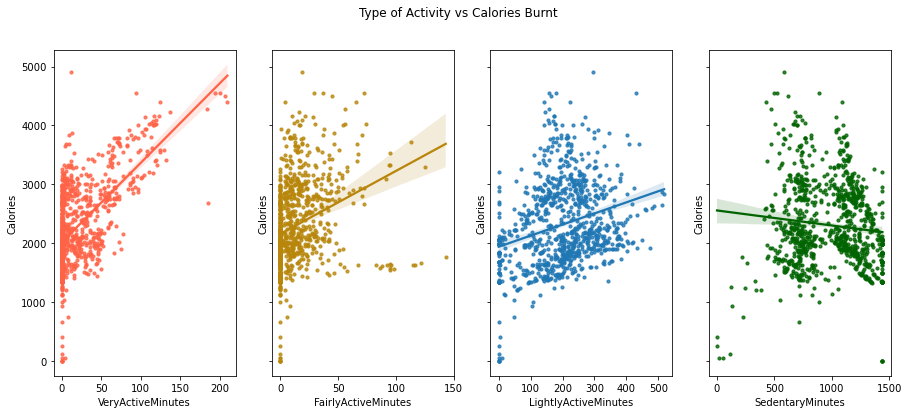

In [34]:
# visualization of different activity time and amount of calories burnt
fig, (ax1, ax2, ax3, ax4) = plt.subplots(nrows=1, ncols=4, sharey=True, figsize=(15,6))

sns.regplot(x='VeryActiveMinutes', y='Calories', data=data_merged, color='tomato', scatter_kws={'s':10}, ax=ax1)
sns.regplot(x='FairlyActiveMinutes', y='Calories', data=data_merged, color='darkgoldenrod', scatter_kws={'s':10}, ax=ax2)
sns.regplot(x='LightlyActiveMinutes', y='Calories', data=data_merged, scatter_kws={'s':10}, ax=ax3)
sns.regplot(x='SedentaryMinutes', y='Calories', data=data_merged, color='darkgreen', scatter_kws={'s':10}, ax=ax4)

plt.suptitle('Type of Activity vs Calories Burnt')
plt.show()

#### 5.1.1.2 Visualization shows the relations between total steps and the amount of calories burnt as well as activity types

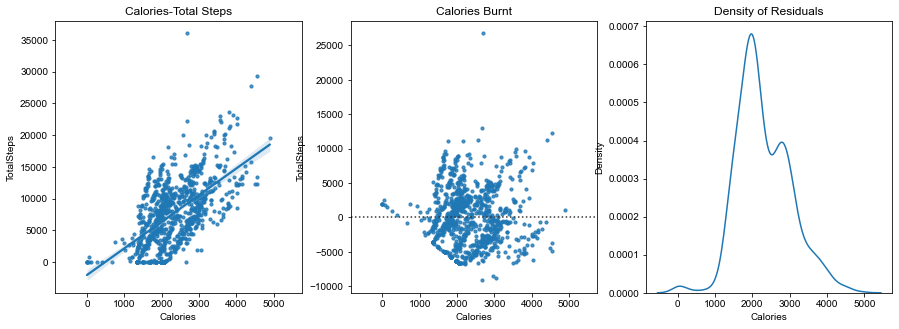

In [35]:
fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, sharex=True, figsize=(15,5))

sns.set_style('darkgrid')
sns.regplot(x='Calories', y='TotalSteps', scatter_kws={'s':10}, 
            data=data_merged, ax=ax1).set_title('Calories-Total Steps')
sns.residplot(x='Calories', y='TotalSteps', scatter_kws={'s':10}, 
              data=data_merged, ax=ax2).set_title('Calories Burnt')
sns.kdeplot(x='Calories', data=data_merged, ax=ax3).set_title('Density of Residuals')

plt.show()

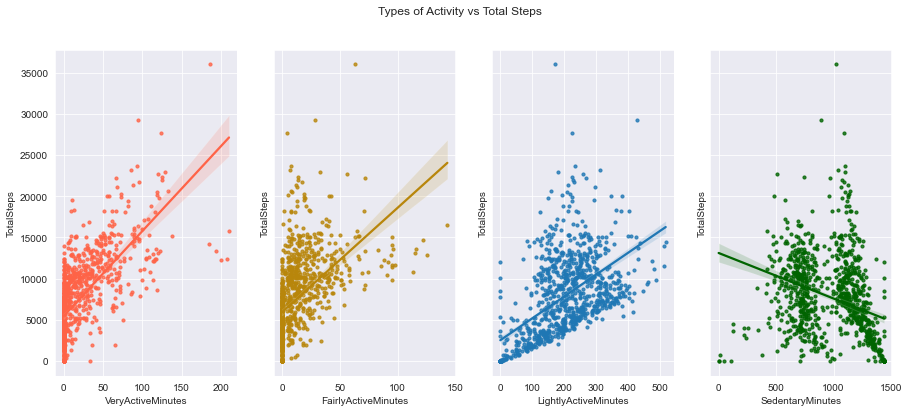

In [36]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(nrows=1, ncols=4, sharey=True, figsize=(15,6))

sns.regplot(x='VeryActiveMinutes', y='TotalSteps', color='tomato', scatter_kws={'s':10}, 
            data=data_merged, ax=ax1)
sns.regplot(x='FairlyActiveMinutes', y='TotalSteps', color='darkgoldenrod', scatter_kws={'s':10}, 
            data=data_merged, ax=ax2)
sns.regplot(x='LightlyActiveMinutes', y='TotalSteps', scatter_kws={'s':10}, 
            data=data_merged, ax=ax3)
sns.regplot(x='SedentaryMinutes', y='TotalSteps', color='darkgreen', scatter_kws={'s':10}, 
            data=data_merged, ax=ax4)

plt.suptitle('Types of Activity vs Total Steps')
plt.show()

#### 5.1.1.3 Visualization shows the relations between total sleep time and active minutes or total time in bed

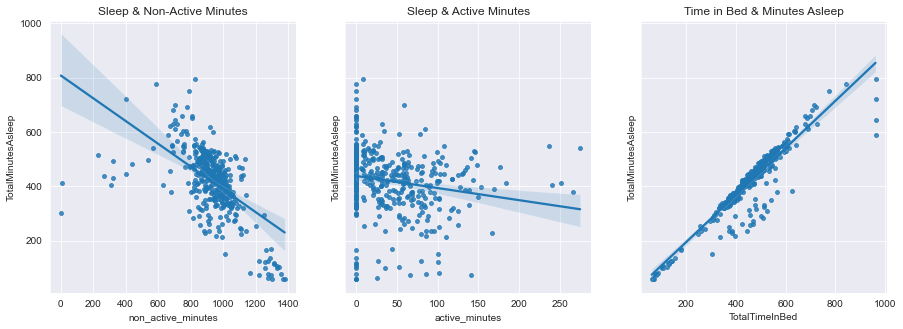

In [37]:
fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, sharey=True, figsize=(15,5))

sns.regplot(x='non_active_minutes', y='TotalMinutesAsleep', scatter_kws={'s':15}, 
            data=sleep_merged, ax=ax1).set_title('Sleep & Non-Active Minutes')
sns.regplot(x='active_minutes', y='TotalMinutesAsleep', scatter_kws={'s':15}, 
            data=sleep_merged, ax=ax2).set_title('Sleep & Active Minutes')
sns.regplot(x='TotalTimeInBed', y='TotalMinutesAsleep', scatter_kws={'s':15}, 
            data=sleep_merged, ax=ax3).set_title('Time in Bed & Minutes Asleep')

plt.show()

#### 5.1.1.4 Visualization shows the relations between boday mass and non-active or active minutes 

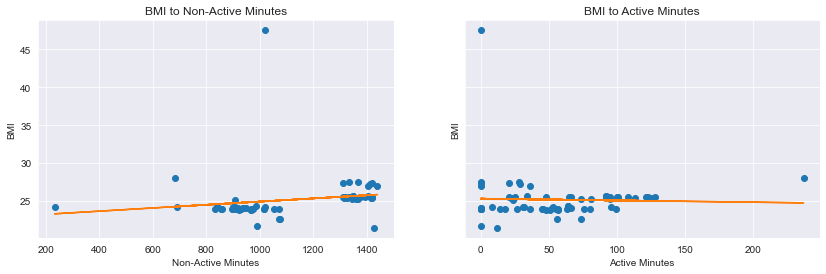

In [38]:
fig, ax = plt.subplots(nrows=1, ncols=2, sharey=True, figsize=(14,4))

ax[0].plot(weight_merged['non_active_minutes'], weight_merged['BMI'], 'o')
m, b = np.polyfit(weight_merged['non_active_minutes'], weight_merged['BMI'], 1)
ax[0].plot(weight_merged['non_active_minutes'], m*weight_merged['non_active_minutes']+b)
ax[0].set(title='BMI to Non-Active Minutes', ylabel='BMI', xlabel='Non-Active Minutes')

ax[1].plot(weight_merged['active_minutes'], weight_merged['BMI'], 'o')
m, b = np.polyfit(weight_merged['active_minutes'], weight_merged['BMI'], 1)
ax[1].plot(weight_merged['active_minutes'], m*weight_merged['active_minutes']+b)
ax[1].set(title='BMI to Active Minutes', ylabel='BMI', xlabel='Active Minutes')

plt.show()

#### 5.1.1.5 Visualization for Time in Bed and Sleep Time

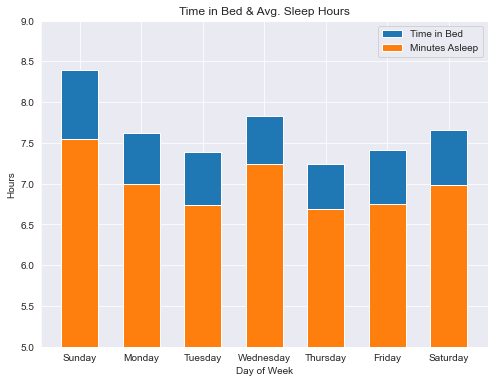

In [39]:
fig, ax = plt.subplots(figsize=(8,6))
labels = sleep_merged.groupby('DayofWeek')['TotalTimeInBed'].mean().index
width = 0.60

ax.bar(labels, sleep_merged.groupby('DayofWeek')['TotalTimeInBed'].mean()/60,
       width, label='Time in Bed')
ax.bar(labels, sleep_merged.groupby('DayofWeek')['TotalMinutesAsleep'].mean()/60,
      width, label='Minutes Asleep')

ax.legend()
ax.set_ylim(5,9)
ax.set_xlabel('Day of Week')
ax.set_ylabel('Hours')
ax.set_title('Time in Bed & Avg. Sleep Hours')

plt.show()

# Step 6: Act
* Since users spend average 16 hours a day in sedentary minutes, it is safe to assume that people not only wear their smart device when they are working out but also they are inactive to track the whole day's activities. So, the design and function of the product should be suitable for the whole day's activities.
* The types of activity have a strong relation with calories. One of the features should stress about that fact and encourage the users to stay active occasionally.
* Although the total distance no relation with types of activity, total steps taken has strong relation to the amount of calories burnt. Thus, counting the steps feature is a must-have for the Bellabeat's product.
* Non-active moments have a strong negative effect on the asleep time. Total time in bed have a strong impact on total time asleep and the users generally take 30 to 50 mintues before they fall asleep. So including the bed time reminder feature would be a great advantage for Bellabeat's product.